📦 1. Import Required Libraries

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

🧼 2. Data Preprocessing

In [6]:
# Image dimensions (increased size for better feature learning)
img_size = (224, 224)  # Larger image size for better feature extraction
batch_size = 32

# Data generators with enhanced augmentation for train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased rotation range
    width_shift_range=0.2,  # Increased width shift range
    height_shift_range=0.2,  # Increased height shift range
    zoom_range=0.2,  # Increased zoom range
    horizontal_flip=True,
    shear_range=0.2,  # Added shear range
    brightness_range=[0.8, 1.2],  # Added brightness variation
    validation_split=0.2  # 20% of the data will be used for validation
)

# Data generator for test set (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Paths to your dataset
train_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/train'
test_path = '/kaggle/input/fer2013plus/fer2013plus/fer2013/test'

# Train data generator (using 80% of the data)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # This uses the 80% training portion
)

# Validation data generator (using 20% of the data)
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # This uses the 20% validation portion
)

# Test data generator (no augmentation, just rescaling)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


🧠 3. Build the Transfer Learning Model

In [9]:
# Build the MobileNetV2 Model with fine-tuning
input_shape = (224, 224, 3)  # Larger input size

# Load the MobileNetV2 base model with pre-trained weights
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = True  # Fine-tune the pre-trained MobileNetV2 model

# Optionally, unfreeze only the top layers (last few layers) for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False  # Freeze the first 100 layers

# Define the model architecture
inputs = Input(shape=input_shape)
x = base_model(inputs, training=True)  # Fine-tuning during training
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Increased dropout rate for regularization
x = BatchNormalization()(x)  # Added batch normalization
x = Dense(256, activation='relu')(x)  # Increased number of neurons
x = Dropout(0.5)(x)  # Increased dropout rate for regularization
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model with the Adam optimizer and a small learning rate
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to check the architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,096 (9.89 MB)

 Trainable params: 2,193,992 (8.37 MB)

 Non-trainable params: 399,104 (1.52 MB)

🧩 4. Train the Model

In [12]:
# Train the model with callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_mobilenet_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5421 - loss: 1.4764
Epoch 1: val_accuracy improved from -inf to 0.61949, saving model to best_mobilenet_model.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 402s 566ms/step - accuracy: 0.5421 - loss: 1.4763 - val_accuracy: 0.6195 - val_loss: 1.3228 - learning_rate: 1.0000e-04
Epoch 2/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6239 - loss: 1.1424
Epoch 2: val_accuracy improved from 0.61949 to 0.68840, saving model to best_mobilenet_model.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 364s 512ms/step - accuracy: 0.6239 - loss: 1.1424 - val_accuracy: 0.6884 - val_loss: 1.0013 - learning_rate: 1.0000e-04
Epoch 3/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6586 - loss: 0.9916
Epoch 3: val_accuracy improved from 0.68840 to 0.69404, saving model to best_mobilenet_model.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 353s 497ms/step - accuracy: 0.6586 - loss: 0.9916 - val_accuracy: 0.6940 - val_loss: 0.9369 - learning_rate: 1.0000

📊 5. Evaluate Accuracy (in %)

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

222/222 ━━━━━━━━━━━━━━━━━━━━ 46s 207ms/step - accuracy: 0.7918 - loss: 0.6106
Test Accuracy: 78.88%
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 376ms/step - accuracy: 0.7705 - loss: 0.6490
Validation Accuracy: 78.30%


📈 6. Plot Accuracy and Loss

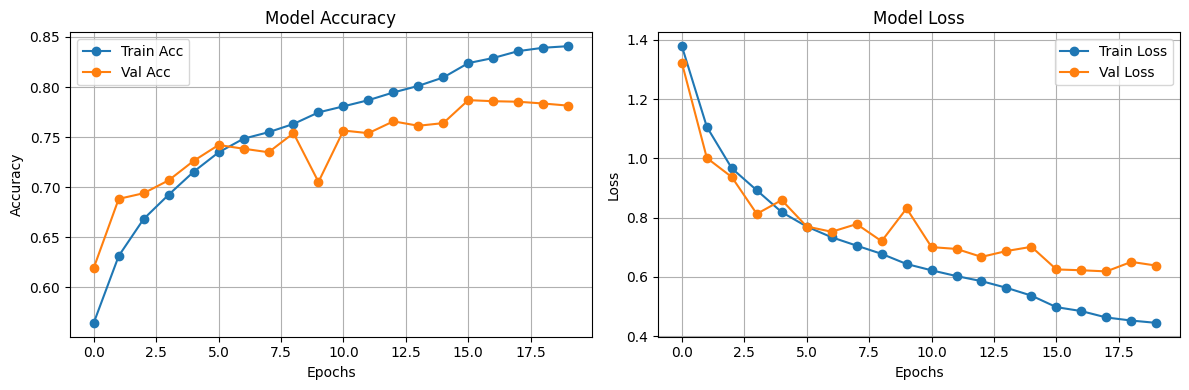

In [14]:
# Plot Accuracy & Loss
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, marker='o', label='Train Acc')
    plt.plot(val_acc, marker='o', label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, marker='o', label='Train Loss')
    plt.plot(val_loss, marker='o', label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)


📌 7. Sample Image Prediction

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_emotion(image_path):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_expanded = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_expanded)[0]
    class_labels = list(train_generator.class_indices.keys())
    predicted_index = np.argmax(prediction)
    predicted_emotion = class_labels[predicted_index]

    # Plotting
    plt.figure(figsize=(10, 5))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_emotion}")

    # Plot prediction probabilities
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_labels, prediction, color='skyblue')
    bars[predicted_index].set_color('green')
    plt.xlabel('Confidence')
    plt.title('Emotion Confidence Scores')

    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{prediction[i]:.2f}', va='center')

    plt.tight_layout()
    plt.show()

    print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


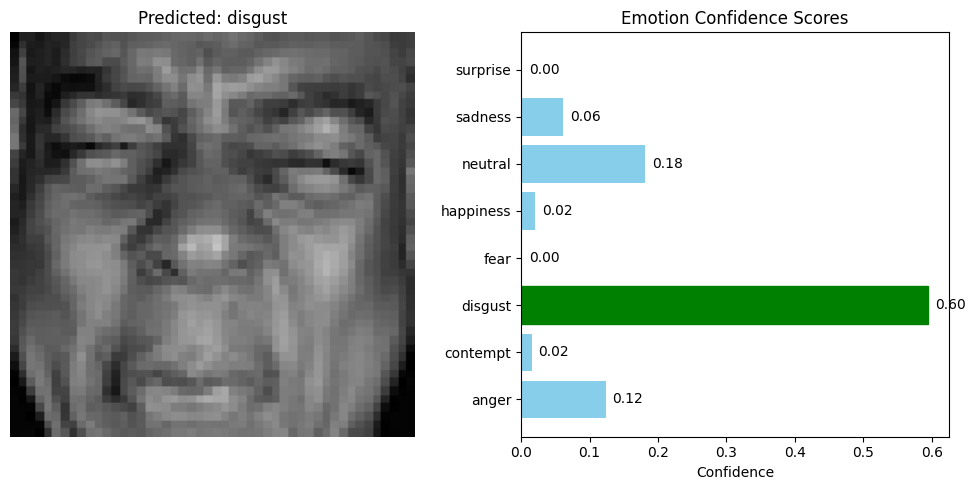

Predicted Emotion: disgust


In [20]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/disgust/fer0029557.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


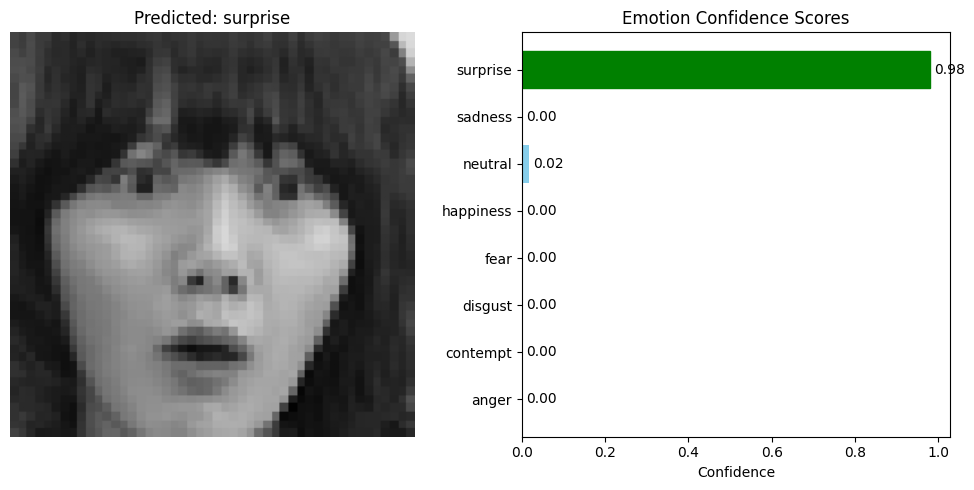

Predicted Emotion: surprise


In [21]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/surprise/fer0028774.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


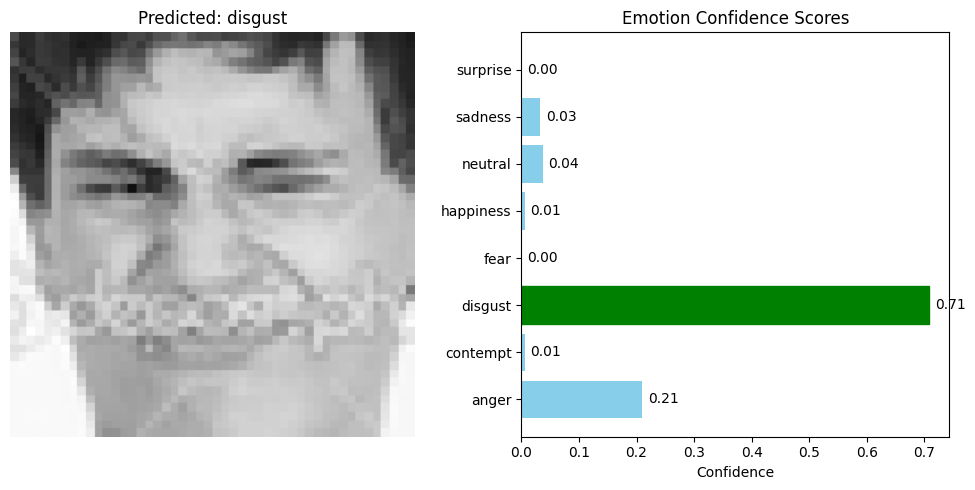

Predicted Emotion: disgust


In [22]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/contempt/fer0032447.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


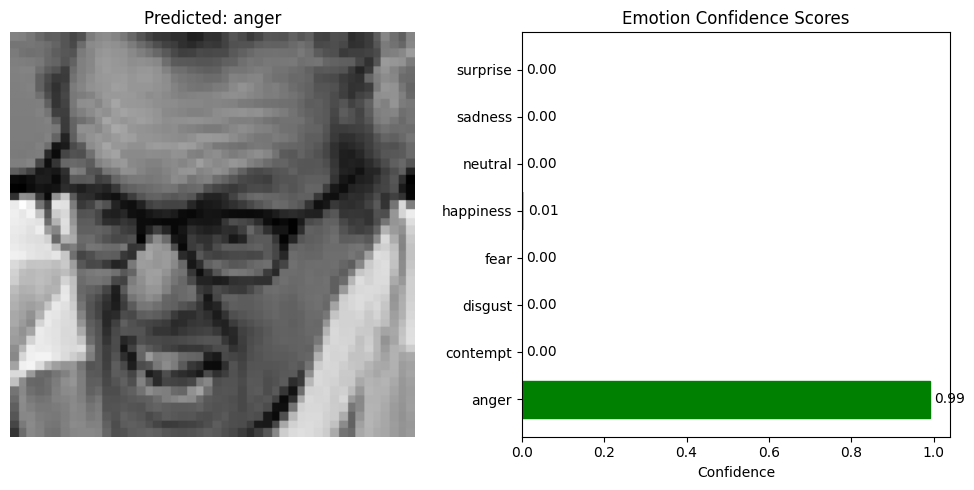

Predicted Emotion: anger


In [23]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028903.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


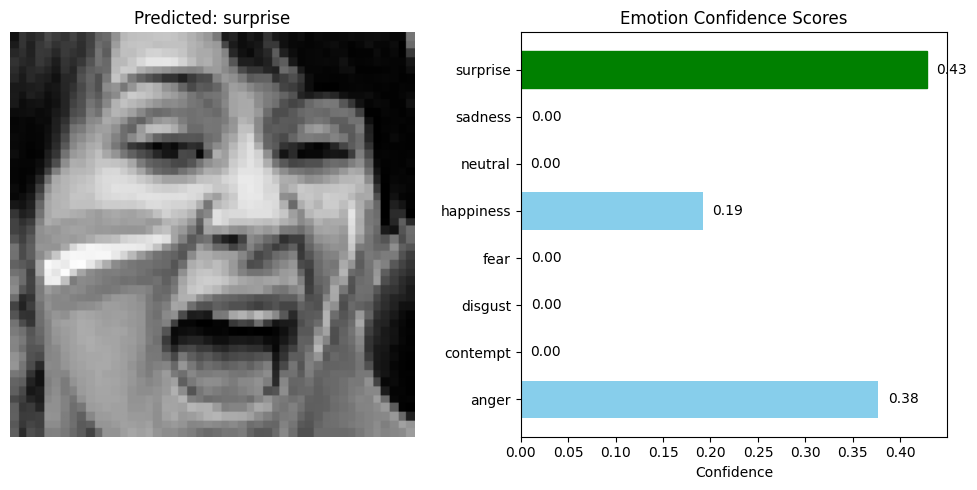

Predicted Emotion: surprise


In [24]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/fear/fer0028976.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


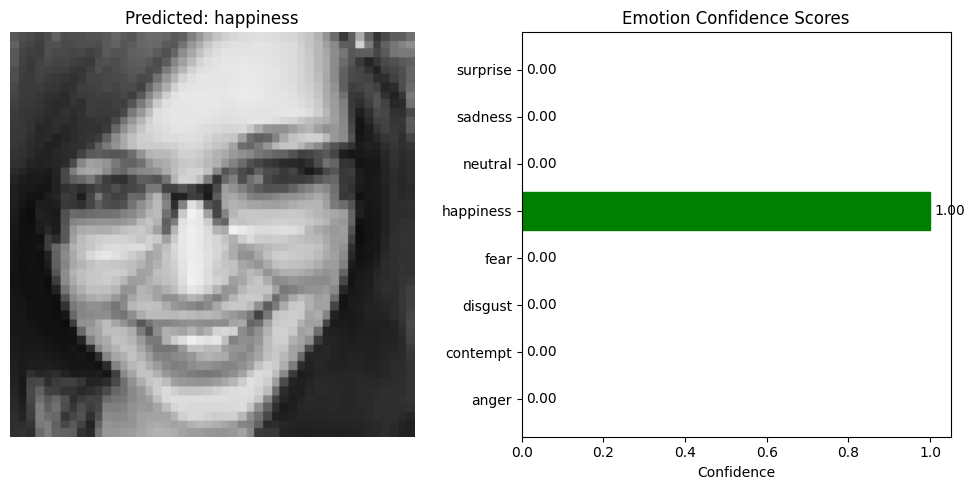

Predicted Emotion: happiness


In [25]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/happiness/fer0028642.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


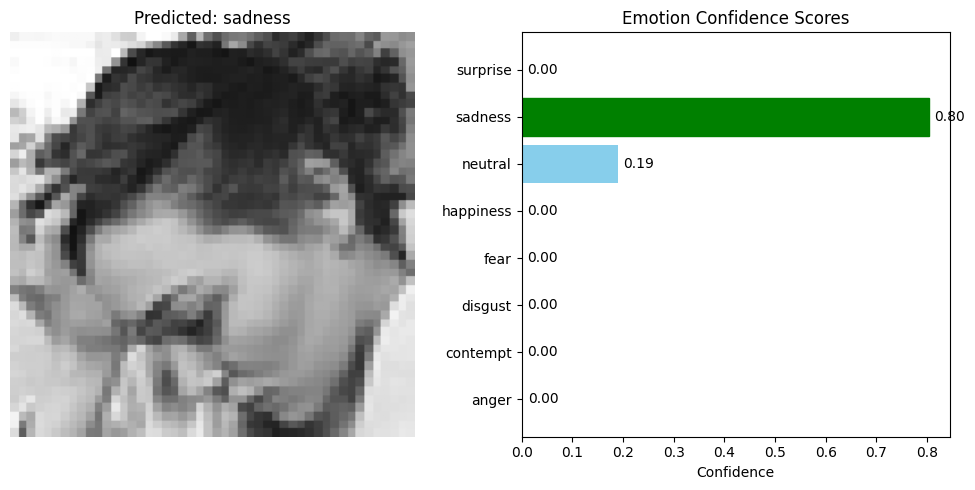

Predicted Emotion: sadness


In [26]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/neutral/fer0028695.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


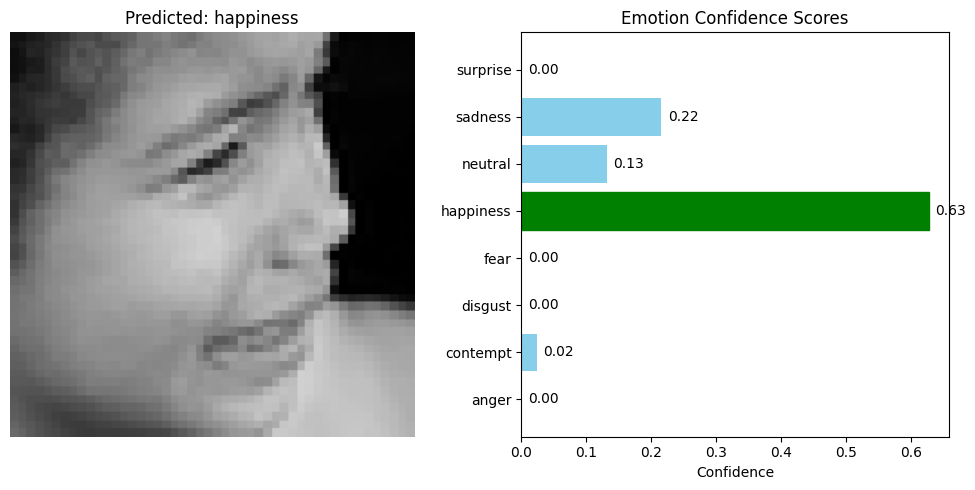

Predicted Emotion: happiness


In [27]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/sadness/fer0028873.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


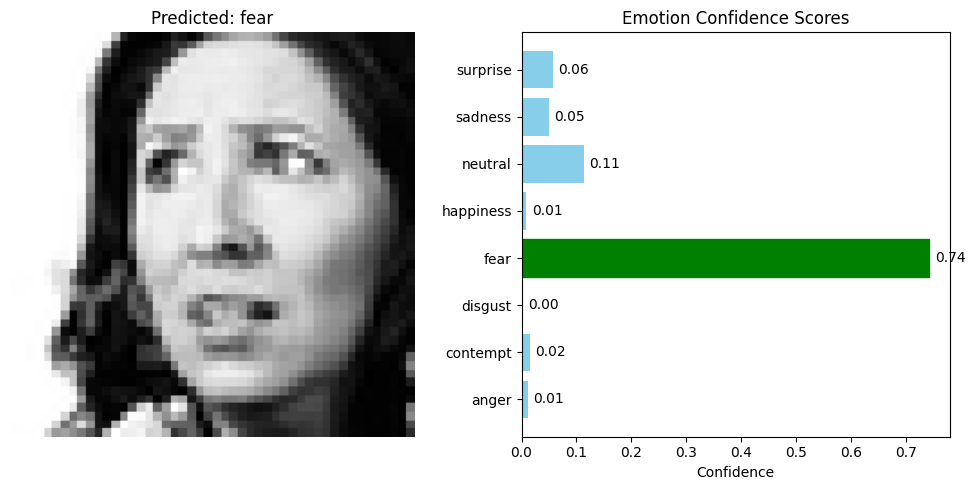

Predicted Emotion: fear


In [28]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/fear/fer0029893.png')

✅ Save the Trained Model

In [29]:
# Save the entire model to a .keras file
model.save('emotion_model_MobileNetV2_V3.keras')

In [30]:
# Save the entire model to a .keras file
model.save('emotion_model_MobileNetV2_V3.h5')